In [1]:
!pip install imutils

In [2]:
import os
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory 

plt.style.use('ggplot')

In [3]:
os.listdir("/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images")

['Uninfected', 'Parasitized']

## ***Load Dataset***

In [4]:
image_size = (224,224)
batch_size = 32
data_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"

train_set = image_dataset_from_directory(data_path, 
                                         label_mode ='categorical',
                                         validation_split=0.2,
                                         subset="training",
                                         seed=1337,
                                         image_size=image_size,
                                         batch_size=batch_size)

validation_set = image_dataset_from_directory(data_path,
                                   label_mode ='categorical',
                                   validation_split=0.2,
                                   subset="validation",
                                   seed=1337,
                                   image_size=image_size,
                                   batch_size=batch_size)

m_train_set = train_set.map(lambda x, y: (preprocess_input(x), y))
m_validation_set = validation_set.map(lambda x, y: (preprocess_input(x), y))

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


## ***Model Construction***

In [5]:
INIT_LR = 3e-5
EPOCHS = 20

In [6]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = True


metrics = ['accuracy',metrics.Precision(name='precision'),metrics.Recall(name='recall')]    
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
plot_model(model,dpi=300)

## ***Model Training***

In [9]:
HR2 = model.fit_generator(m_train_set, steps_per_epoch=16, validation_data = m_validation_set, validation_steps=8, epochs=EPOCHS)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
16/16 [==============================] - 17s 570ms/step - loss: 0.7183 - accuracy: 0.5876 - precision: 0.5876 - recall: 0.5876 - val_loss: 0.5762 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 0.7422
Epoch 2/20
16/16 [==============================] - 7s 447ms/step - loss: 0.4961 - accuracy: 0.7530 - precision: 0.7530 - recall: 0.7530 - val_loss: 0.3689 - val_accuracy: 0.8398 - val_precision: 0.8398 - val_recall: 0.8398
Epoch 3/20
16/16 [==============================] - 7s 449ms/step - loss: 0.3883 - accuracy: 0.8279 - precision: 0.8279 - recall: 0.8279 - val_loss: 0.2198 - val_accuracy: 0.9180 - val_precision: 0.9180 - val_recall: 0.9180
Epoch 4/20
16/16 [==============================] - 7s 449ms/step - loss: 0.2706 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - val_loss: 0.2208 - val_accuracy: 0.9258 - val_precision: 0.9258 - val_recall: 0.9258
Epoch 5/20
16/16 [==============================] - 7s 438ms/step - loss: 0.2019 - accuracy: 0.9257 - p

## ***Performance Analysis***

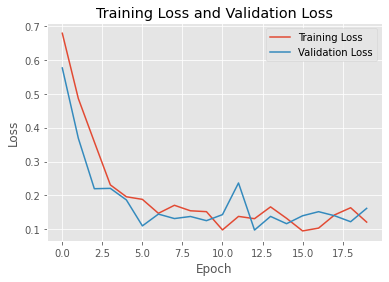

In [10]:
N = EPOCHS

plt.figure()
plt.plot(np.arange(0, N), HR2.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), HR2.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

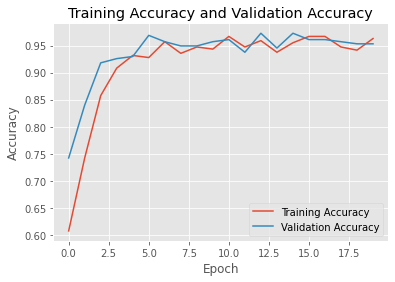

In [11]:
plt.figure()
plt.plot(np.arange(0, N), HR2.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, N), HR2.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

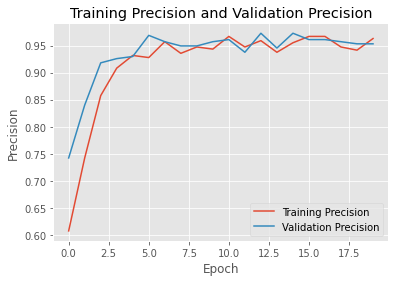

In [12]:
plt.figure()
plt.plot(np.arange(0, N), HR2.history["precision"], label="Training Precision")
plt.plot(np.arange(0, N), HR2.history["val_precision"], label="Validation Precision")
plt.title("Training Precision and Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend(loc="lower right")

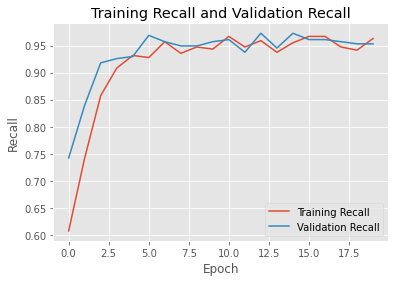

In [13]:
plt.figure()
plt.plot(np.arange(0, N), HR2.history["recall"], label="Training Recall")
plt.plot(np.arange(0, N), HR2.history["val_recall"], label="Validation Recall")
plt.title("Training Recall and Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend(loc="lower right")

## ***Predictions on Random Images***

In [14]:
parasitized_path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/'
uninfected_path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/'

In [15]:
def mapper(val):
    if val==0:
        return 'Parasitized'
    elif val ==1:
        return 'Uninfected'

In [16]:
def genPred(PATH,image):
    o_test_image = cv2.imread(os.path.join(PATH, image))
    o_test_image = cv2.cvtColor(o_test_image, cv2.COLOR_BGR2RGB)

    test_image = cv2.resize(o_test_image, image_size)
    test_image = preprocess_input(test_image)
    test_image = np.expand_dims(test_image, axis = 0)

    y_hat = model.predict(test_image)
    y_hat = np.argmax(y_hat, axis=1)
    pred_lab = mapper(y_hat)

    print("ORIGINAL LABEL: "+PATH.split('/')[-2])
    print("PREDICTED LABEL: "+pred_lab)
    print("------------------------------------------------------------------------")
    print("")

    plt.imshow(o_test_image)

ORIGINAL LABEL: Parasitized
PREDICTED LABEL: Parasitized
------------------------------------------------------------------------



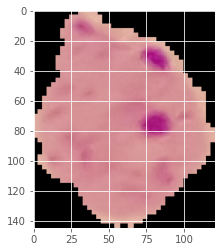

In [17]:
genPred(parasitized_path, 'C101P62ThinF_IMG_20150918_151239_cell_74.png')

ORIGINAL LABEL: Parasitized
PREDICTED LABEL: Parasitized
------------------------------------------------------------------------



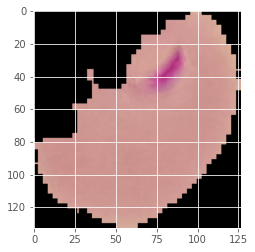

In [18]:
genPred(parasitized_path, 'C100P61ThinF_IMG_20150918_145422_cell_163.png')

ORIGINAL LABEL: Parasitized
PREDICTED LABEL: Parasitized
------------------------------------------------------------------------



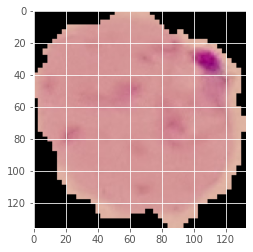

In [19]:
genPred(parasitized_path, 'C101P62ThinF_IMG_20150918_151239_cell_87.png')

ORIGINAL LABEL: Uninfected
PREDICTED LABEL: Uninfected
------------------------------------------------------------------------



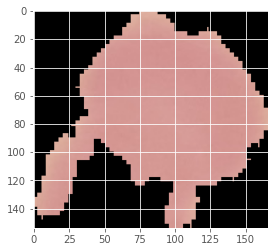

In [20]:
genPred(uninfected_path, 'C100P61ThinF_IMG_20150918_145042_cell_161.png')

ORIGINAL LABEL: Uninfected
PREDICTED LABEL: Uninfected
------------------------------------------------------------------------



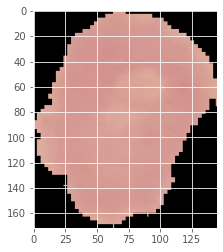

In [21]:
genPred(uninfected_path, 'C100P61ThinF_IMG_20150918_144348_cell_108.png')

ORIGINAL LABEL: Uninfected
PREDICTED LABEL: Uninfected
------------------------------------------------------------------------



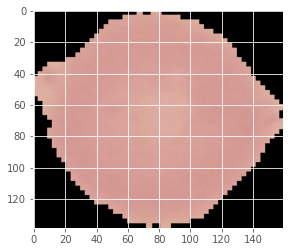

In [22]:
genPred(uninfected_path, 'C100P61ThinF_IMG_20150918_144104_cell_128.png')